In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# Set up variables

In [2]:
# Problem data.
m = 4
n_values = [25, 50, 100, 250, 500, 1000]
b = np.ones(m)

In [3]:
# Number of times to solve the dual equation.
num_dual_samples = 1000

# Number of times to solve the stochastic equation.
num_stoc_samples = 10**5

In [4]:
# Set random seed for reproducability.

np.random.seed(23)

In [5]:
def generate_pi():
    rv = np.random.uniform(0, 1)
    return 2**(int(-1*np.log2(rv)) + 1)

In [6]:
def generate_pi(a):
    rv = np.random.uniform(0, 1)
    return 2**(int(-1*np.log2(rv)) + 1)

# Solve for the stochastic program

In [7]:
# Solve for the stochastic program.

# This is deterministic.

# From TA office hours: We cannot use the expectations
# of A and pi instead of their samples of A and pi,
# because we cannot exchange the function and inequality.
# Therefore, we have to generate very many samples of A 
# and pi, and truly calculate the expectation.
print("Stochastic Program Results")

# Create dictionary to store stochastic program results
n_to_stochastic_p = dict()

start = time.time()

for n in n_values:
    # Solve the stochastic problem.
    d = b / n
    
    # Construct the stochastic problem.
    p = cp.Variable(m)
    
    A = np.random.uniform(-0.5, 1, (m, num_stoc_samples))
    pi = generate_pi(0)
        
    objective = cp.Minimize((d @ p) + (1/num_stoc_samples)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p))))

    constraints = [p >= 0]

    prob = cp.Problem(objective, constraints)

    # Solve the stochastic problem.
    result = prob.solve()
    now = time.time()
    print("\nWith n=%d, iteration completed in %.2f s" % (n, now - start))
    print(p.value)
    
    n_to_stochastic_p[n] = p.value
    

Stochastic Program Results

With n=25, iteration completed in 1.98 s
[3.92044282 3.87976222 3.95645312 3.90102621]

With n=50, iteration completed in 4.10 s
[4.78023616 4.81300487 4.81545186 4.87688688]

With n=100, iteration completed in 7.00 s
[45.25896191 45.545461   45.21147475 45.55465293]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



With n=250, iteration completed in 14.17 s
[13.01839406 12.9140853  12.8540231  12.90142947]

With n=500, iteration completed in 16.67 s
[3.36141135 3.39605558 3.45632204 3.37752064]

With n=1000, iteration completed in 23.63 s
[3.59735683 3.53872058 3.58483521 3.56519168]


# Solve for the dual problem for various values of n

In [8]:
# Create dictionaries to save results of simulations

n_to_diffs = dict()
n_to_mean_diffs = dict()
n_to_log_factors = dict()
n_to_C = dict()

##########################################################
# Solve the dual problem.
    
for n in n_values:
    d = b / n
    
    # Create an array to store all of the simulations.
    p_n_values = np.zeros((num_dual_samples, m))
    
    # Solve for one iteration of the offline dual optimal solution.
    for i in range(num_dual_samples):
        # Generate sample A_j and pi_j's (all at once in array)
        
        A = np.random.uniform(-0.5, 1, (m, n))
        pi = np.fromfunction(generate_pi, (n,))

        
        # Construct the stochastic problem.
        p_n = cp.Variable(m)

        # We could do the sum of up to t terms if this was truly online;
        # however since this is offline we can use matrix operations.

        objective = cp.Minimize((d @ p_n) + (1/n)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p_n))))

        constraints = [p_n >= 0]

        prob = cp.Problem(objective, constraints)

        # Solve the offline dual problem.
        result = prob.solve()

        p_n_values[i] = p_n.value
        
        
    
    # Compute the 2-norm difference from the stochastic solution
    diffs = [np.linalg.norm(p_n_values[i]-n_to_stochastic_p[n], ord=2)**2 for i in range(num_dual_samples)]
    
    # Compute the log difference based on m and n
    log_factor = m*np.log(m)*np.log(np.log(n))/n
    
    # Compute the coefficient C from dividing the mean of the differences by the log_factor
    C = np.mean(diffs) / log_factor
    
    # Save all results to the dictionary
    n_to_diffs[n] = diffs
    n_to_mean_diffs[n] = np.mean(diffs)
    n_to_log_factors[n] = log_factor
    n_to_C[n] = C
    
    # Print results
    print("For n = %d" % (n))
    print("Average of all dual solutions: %s" % (np.mean(p_n_values, axis=0)))
    print("Expectation of L2 norm between p*n and p* is: %.2f" % (np.mean(diffs)))
    print("m log m log log n / n for m=%d and n=%d is: %.2f" % (m, n, log_factor))
    print("Constant C is: %.3f\n" % (C))

For n = 25
Average of all dual solutions: [22.78407623 13.12128739 19.78872597 20.95160452]
Expectation of L2 norm between p*n and p* is: 176937.42
m log m log log n / n for m=4 and n=25 is: 0.26
Constant C is: 682366.649

For n = 50
Average of all dual solutions: [15.39481872 12.87048415 14.0580154  15.93701173]
Expectation of L2 norm between p*n and p* is: 43701.60
m log m log log n / n for m=4 and n=50 is: 0.15
Constant C is: 288881.791

For n = 100
Average of all dual solutions: [12.35184829 12.67707635 12.32700173 12.61951033]
Expectation of L2 norm between p*n and p* is: 11267.15
m log m log log n / n for m=4 and n=100 is: 0.08
Constant C is: 133048.088

For n = 250
Average of all dual solutions: [31.21793204 31.88580269 33.02545071 32.0662325 ]
Expectation of L2 norm between p*n and p* is: 269982.31
m log m log log n / n for m=4 and n=250 is: 0.04
Constant C is: 7123749.967

For n = 500
Average of all dual solutions: [18.53626289 18.21711961 18.44819932 18.57173129]
Expectation 

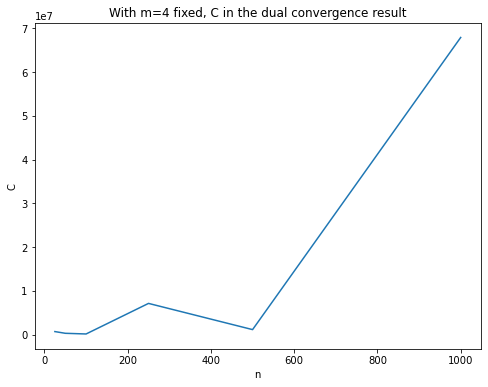

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_C.keys()), list(n_to_C.values()))
plt.xlabel("n")
plt.ylabel("C")
plt.title("With m=%d fixed, C in the dual convergence result" % (m))
plt.show()

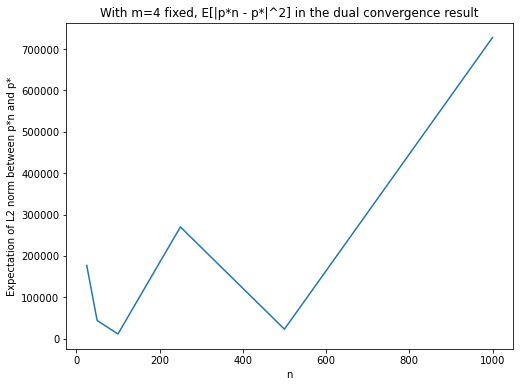

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_diffs.keys()), list(n_to_mean_diffs.values()))
plt.xlabel("n")
plt.ylabel("Expectation of L2 norm between p*n and p*")
plt.title("With m=%d fixed, E[|p*n - p*|^2] in the dual convergence result" % (m))
plt.show()